**Import Libraries**

In [718]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats
import pylab
import datetime
from time import time
import seaborn as sns
sns.set()
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

#time series Libraries
import statsmodels.graphics.tsaplots as sgt 
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller

**Import the data**

In [719]:
raw_csv_data = pd.read_csv("sentech_data.csv")

**Make a copy of original data**

In [720]:
sentech_data= raw_csv_data.copy()

In [721]:
sentech_data

,Date,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Lightning_Warnings,Reset_secs
0,2/27/2022 23:45,15.31052,85.83740,12.966850,0.0,827.4857,-16.63182,0,0
1,2/27/2022 23:30,15.98598,82.16581,12.960260,0.0,827.4928,-17.88704,0,0
2,2/27/2022 23:15,15.81320,81.01760,12.576650,0.0,827.6407,-17.25920,0,0
3,2/27/2022 23:00,15.94644,79.59342,12.436280,0.0,827.6857,-15.37659,0,0
4,2/27/2022 22:45,16.28638,76.22140,12.107980,0.0,827.9321,-14.43517,0,0
...,...,...,...,...,...,...,...,...,...
11405,11/1/2021 1:00,14.49834,72.94492,9.719332,0.0,823.9849,-23.84927,0,0
11406,11/1/2021 0:45,14.64727,71.04126,9.468879,0.0,824.1239,-23.22135,0,0
11407,11/1/2021 0:30,15.17229,67.91439,9.302760,0.0,824.1583,-23.84614,0,0
11408,11/1/2021 0:15,15.88538,60.16803,8.188042,0.0,824.1832,-23.84491,0,0


In [722]:
sentech_data.describe()

,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Lightning_Warnings,Reset_secs
count,11410.000000,11410.000000,11410.000000,11410.000000,11410.000000,11410.000000,11410.000000,11410.000000
mean,18.689568,72.150754,12.816222,0.000035,826.438567,-19.921106,0.108589,314.438212
std,3.924400,20.393162,3.102967,0.002648,15.626958,236.783167,0.311136,965.151379
min,0.000000,0.000000,-3.143647,0.000000,0.000000,-2523.927000,0.000000,0.000000
25%,15.754948,57.802200,11.778005,0.000000,825.406050,-41.416790,0.000000,0.000000
50%,18.324115,74.139575,13.451890,0.000000,826.824550,-29.796630,0.000000,0.000000
75%,21.584875,89.270905,14.794128,0.000000,828.125875,-19.456090,0.000000,0.000000
max,29.734370,99.980700,19.050590,0.200000,833.690200,2562.246000,1.000000,3600.000000


In [723]:
sentech_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11410 entries, 0 to 11409
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                11410 non-null  object 
 1   Air_temp            11410 non-null  float64
 2   RH                  11410 non-null  float64
 3   DewPoint            11410 non-null  float64
 4   Rain                11410 non-null  float64
 5   Pressure            11410 non-null  float64
 6   Efield              11410 non-null  float64
 7   Lightning_Warnings  11410 non-null  int64  
 8   Reset_secs          11410 non-null  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 802.4+ KB


**Check Stationarity & Visualize data**

Stationarity:

In [724]:
def generate_ar_process(lags, coefs, length):
    
    #cast coefs to np array
    coefs = np.array(coefs)
    
    #initial values
    series = [np.random.normal() for _ in range(lags)]
    
    for _ in range(length):
        #get previous values of the series, reversed
        prev_vals = series[-lags:][::-1]
        
        #get new value of time series
        new_val = np.sum(np.array(prev_vals) * coefs) + np.random.normal()
        
        series.append(new_val)
        
    return np.array(series)

In [725]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

Electric field Stationarity

In [726]:
perform_adf_test(sentech_data.Efield)

ADF Statistic: -23.326738
p-value: 0.000000


Air Temperature Stationarity

In [727]:
perform_adf_test(sentech_data.Air_temp)

ADF Statistic: -16.509875
p-value: 0.000000


Dew Point Stationarity

In [728]:
perform_adf_test(sentech_data.DewPoint)

ADF Statistic: -7.925131
p-value: 0.000000


Realative Humidity Stationarity

In [729]:
perform_adf_test(sentech_data.RH)

ADF Statistic: -13.005040
p-value: 0.000000


E_Field Warnings Stationarity

In [730]:
perform_adf_test(sentech_data.Lightning_Warnings)

ADF Statistic: -16.364931
p-value: 0.000000


Graphs:

<AxesSubplot:title={'center':'Electric Field'}>

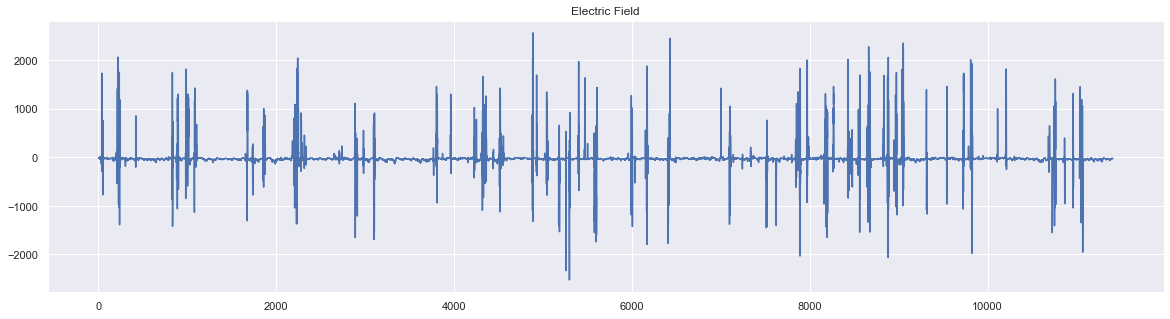

In [731]:
sentech_data.Efield.plot(figsize= (20,5), title= "Electric Field")

<AxesSubplot:title={'center':'Lightning Warnings'}>

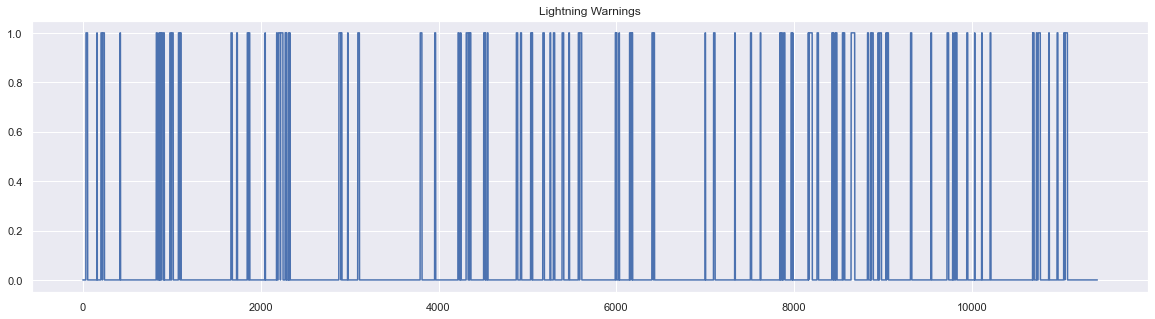

In [732]:
sentech_data.Lightning_Warnings.plot(figsize= (20,5), title= "Lightning Warnings")

**NormalizeElectric Field and Lightning Warnings**

In [733]:
from sklearn import preprocessing

In [734]:
normalized_Efild = preprocessing.normalize([sentech_data.Efield])
print(normalized_Efild)

[[-0.00065529 -0.00070475 -0.00068001 ... -0.00093953 -0.00093948
  -0.00124852]]


In [735]:
normalized_Warnings = preprocessing.normalize([sentech_data.Lightning_Warnings])
print(normalized_Warnings)

[[0. 0. 0. ... 0. 0. 0.]]


In [736]:
df_Normalized_Efield = pd.DataFrame(normalized_Efild).transpose()

In [737]:
sentech_data['_Normalized_Efield']= df_Normalized_Efield

In [738]:
df_Normalized_Warnings = pd.DataFrame(normalized_Warnings).transpose()

In [739]:
sentech_data['_Normalized_Warnings']= df_Normalized_Warnings

In [740]:
#Export normalized set as csv file
sentech_data.to_csv('Normalized_Efield_Warnings.csv')

**Plot the graphs of Lightning Warnings vs ALL OTHER PARAMETERS**

Text(0.5, 1.0, 'Electric field vs Lightning Warnings')

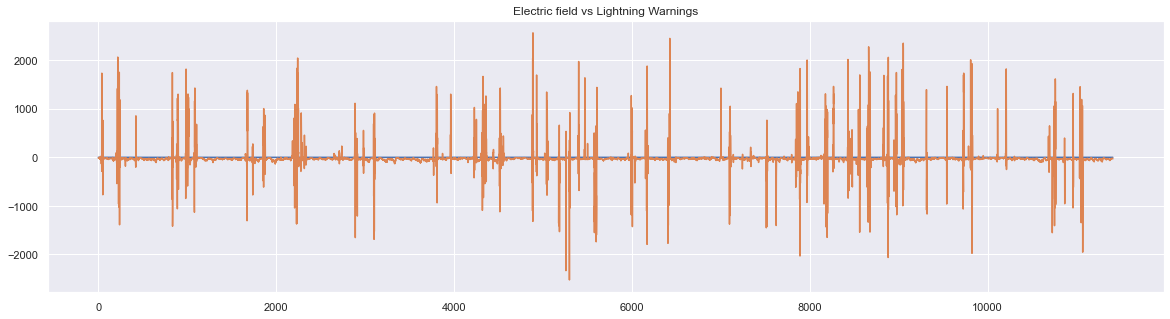

In [741]:
sentech_data.Lightning_Warnings.plot(figsize= (20,5), title= "Lightning Warnings")
sentech_data.Efield.plot(figsize= (20,5), title= "Electric Field")
plt.title("Electric field vs Lightning Warnings")

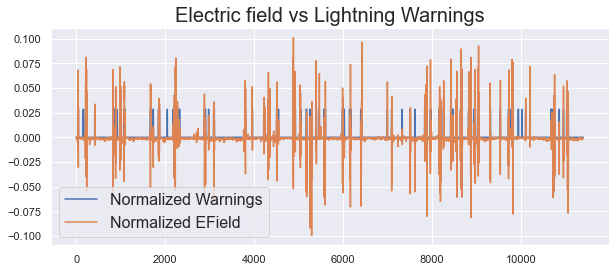

In [742]:
plt.figure(figsize=(10,4))

plt.plot(sentech_data._Normalized_Warnings)
plt.plot(sentech_data._Normalized_Efield)

plt.legend(('Normalized Warnings', 'Normalized EField'), fontsize=16)
plt.title('Electric field vs Lightning Warnings', fontsize=20)
for year in range(2022,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Lightning Warnings')

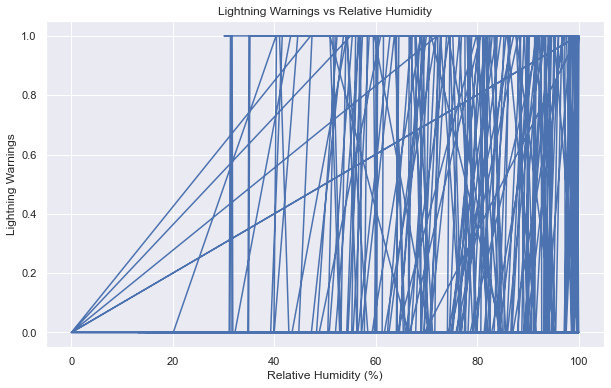

In [743]:
plt.plot(sentech_data.RH, sentech_data.Lightning_Warnings)
plt.title('Lightning Warnings vs Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Lightning Warnings')

Text(0, 0.5, 'Lightning Warnings')

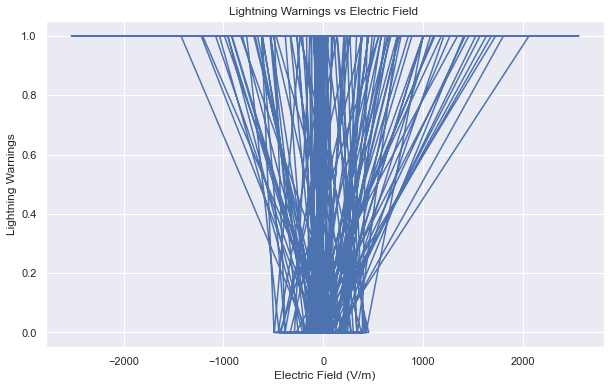

In [744]:
plt.plot(sentech_data.Efield, sentech_data.Lightning_Warnings)
plt.title('Lightning Warnings vs Electric Field ')
plt.xlabel('Electric Field (V/m)')
plt.ylabel('Lightning Warnings')

Text(0, 0.5, 'Lightning Warnings')

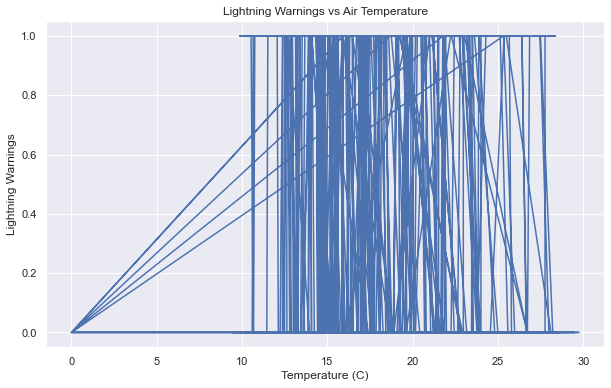

In [745]:
plt.plot(sentech_data.Air_temp, sentech_data.Lightning_Warnings)
plt.title('Lightning Warnings vs Air Temperature')
plt.xlabel('Temperature (C)')
plt.ylabel('Lightning Warnings')

Text(0, 0.5, 'Lightning Warnings')

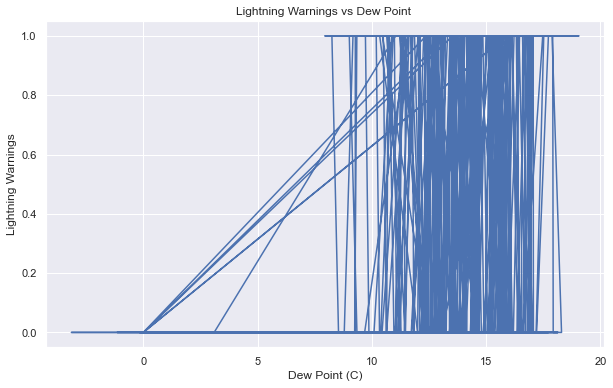

In [746]:
plt.plot(sentech_data.DewPoint, sentech_data.Lightning_Warnings)
plt.title('Lightning Warnings vs Dew Point ')
plt.xlabel('Dew Point (C)')
plt.ylabel('Lightning Warnings')

**Convert date to Index**

In [747]:
sentech_data.Date = pd.to_datetime(sentech_data.Date)

In [748]:
sentech_data.Date.describe(datetime_is_numeric=True)

count                            11410
mean     2021-12-30 13:12:09.386503168
min                2021-11-01 00:00:00
25%                2021-11-30 20:33:45
50%                2021-12-30 13:37:30
75%                2022-01-29 06:41:15
max                2022-02-27 23:45:00
Name: Date, dtype: object

In [749]:
sentech_data.set_index("Date", inplace=True)

In [750]:
#Reverse train set to begin with most oldest date
sentech_data= sentech_data.iloc[::-1]

In [751]:
sentech_data

,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Lightning_Warnings,Reset_secs,_Normalized_Efield,_Normalized_Warnings
Date,,,,,,,,,,
2021-11-01 00:00:00,18.83013,44.34569,6.449132,0.0,823.9045,-31.68846,0,0,-0.001249,0.0
2021-11-01 00:15:00,15.88538,60.16803,8.188042,0.0,824.1832,-23.84491,0,0,-0.000939,0.0
2021-11-01 00:30:00,15.17229,67.91439,9.302760,0.0,824.1583,-23.84614,0,0,-0.000940,0.0
2021-11-01 00:45:00,14.64727,71.04126,9.468879,0.0,824.1239,-23.22135,0,0,-0.000915,0.0
2021-11-01 01:00:00,14.49834,72.94492,9.719332,0.0,823.9849,-23.84927,0,0,-0.000940,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-02-27 22:45:00,16.28638,76.22140,12.107980,0.0,827.9321,-14.43517,0,0,-0.000569,0.0
2022-02-27 23:00:00,15.94644,79.59342,12.436280,0.0,827.6857,-15.37659,0,0,-0.000606,0.0
2022-02-27 23:15:00,15.81320,81.01760,12.576650,0.0,827.6407,-17.25920,0,0,-0.000680,0.0


**Setting the desired frequency (15 min intervals)**

In [752]:
sentech_data=sentech_data.asfreq('900s')

**Handling Missing Values**

In [753]:
sentech_data.isna().sum()

Air_temp                14
RH                      14
DewPoint                14
Rain                    14
Pressure                14
Efield                  14
Lightning_Warnings      14
Reset_secs              14
_Normalized_Efield      14
_Normalized_Warnings    14
dtype: int64

In [754]:
sentech_data.Air_temp=sentech_data.Air_temp.fillna(method='bfill')

In [755]:
sentech_data.RH=sentech_data.RH.fillna(method='bfill')

In [756]:
sentech_data.DewPoint=sentech_data.DewPoint.fillna(method='bfill')

In [757]:
sentech_data.Pressure=sentech_data.Pressure.fillna(method='bfill')

In [758]:
sentech_data.Efield=sentech_data.Efield.fillna(method='bfill')

In [759]:
sentech_data.Lightning_Warnings=sentech_data.Lightning_Warnings.fillna(method='bfill')

In [760]:
sentech_data.Rain=sentech_data.Rain.fillna(method='bfill')

In [761]:
sentech_data.Reset_secs=sentech_data.Reset_secs.fillna(method='bfill')

In [762]:
sentech_data._Normalized_Efield=sentech_data._Normalized_Efield .fillna(method='bfill')

In [763]:
sentech_data._Normalized_Warnings=sentech_data._Normalized_Warnings .fillna(method='bfill')

In [764]:
sentech_data.isna().sum()

Air_temp                0
RH                      0
DewPoint                0
Rain                    0
Pressure                0
Efield                  0
Lightning_Warnings      0
Reset_secs              0
_Normalized_Efield      0
_Normalized_Warnings    0
dtype: int64

In [765]:
#Export normalized set as csv file
sentech_data.to_csv('Complete_Sentech_Tower_Data.csv')

**More Sophisticated Data Exploration**

In [766]:
##Total Number of lightning warnings
warning = sentech_data[sentech_data.Lightning_Warnings==1]
warning.shape

(1239, 10)

In [767]:
##NO Lightning Warning Given
normal_condition = sentech_data[sentech_data.Lightning_Warnings==0]
normal_condition.shape

(10185, 10)

Average of all columns per wether there is lighning or not

In [768]:
sentech_data.groupby('Lightning_Warnings').mean()

,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Reset_secs,_Normalized_Efield,_Normalized_Warnings
Lightning_Warnings,,,,,,,,,
0.0,18.873257,70.585354,12.664526,0.000000,825.271119,-31.905660,0.000000,-0.001257,0.00000
1.0,16.968407,84.203604,13.918395,0.000323,826.697096,78.821091,2895.673931,0.003106,0.02841


**CORRELATIONS**

In [769]:
sentech_data.corr()

,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Lightning_Warnings,Reset_secs,_Normalized_Efield,_Normalized_Warnings
Air_temp,1.000000,-0.787702,-0.077273,-0.015733,0.167639,-0.039332,-0.148976,-0.142931,-0.039332,-0.148976
RH,-0.787702,1.000000,0.612915,0.010354,0.154772,0.054286,0.206212,0.197879,0.054286,0.206212
DewPoint,-0.077273,0.612915,1.000000,-0.003409,0.166715,0.036891,0.124441,0.119576,0.036891,0.124441
Rain,-0.015733,0.010354,-0.003409,1.000000,0.000342,-0.050214,0.037939,0.045078,-0.050214,0.037939
Pressure,0.167639,0.154772,0.166715,0.000342,1.000000,-0.002614,0.013494,0.012914,-0.002614,0.013494
Efield,-0.039332,0.054286,0.036891,-0.050214,-0.002614,1.000000,0.145507,0.170194,1.000000,0.145507
Lightning_Warnings,-0.148976,0.206212,0.124441,0.037939,0.013494,0.145507,1.000000,0.933489,0.145507,1.000000
Reset_secs,-0.142931,0.197879,0.119576,0.045078,0.012914,0.170194,0.933489,1.000000,0.170194,0.933489
_Normalized_Efield,-0.039332,0.054286,0.036891,-0.050214,-0.002614,1.000000,0.145507,0.170194,1.000000,0.145507
_Normalized_Warnings,-0.148976,0.206212,0.124441,0.037939,0.013494,0.145507,1.000000,0.933489,0.145507,1.000000


In [770]:
#Correlation Matrix- Self Correlation
# using shift function to shift the values.
values= pd.DataFrame(sentech_data.Lightning_Warnings)

dataframe = pd.concat([values.shift(3), values.shift(2),
                       values.shift(1), values], axis=1)
# naming the columns
dataframe.columns = ['t', 't+1', 't+2', 't+3']
 
# using corr() function to compute the correlation
result = dataframe.corr()
 
print(result)

            t       t+1       t+2       t+3
t    1.000000  0.904037  0.810789  0.726595
t+1  0.904037  1.000000  0.904038  0.810791
t+2  0.810789  0.904038  1.000000  0.904039
t+3  0.726595  0.810791  0.904039  1.000000


**Simplyifying the data set**

In [771]:
# Create a new column extracted from sentech tower
sentech_data['warnings']=sentech_data.Lightning_Warnings

In [772]:
#Delete the other columns
del sentech_data['Air_temp']
del sentech_data['DewPoint']
del sentech_data['Rain']
del sentech_data['Pressure']
del sentech_data['Lightning_Warnings']
del sentech_data['Reset_secs']
del sentech_data['_Normalized_Warnings']
del sentech_data['Efield']
del sentech_data['_Normalized_Efield']

In [773]:
sentech_data

,RH,warnings
Date,,
2021-11-01 00:00:00,44.34569,0.0
2021-11-01 00:15:00,60.16803,0.0
2021-11-01 00:30:00,67.91439,0.0
2021-11-01 00:45:00,71.04126,0.0
2021-11-01 01:00:00,72.94492,0.0
...,...,...
2022-02-27 22:45:00,76.22140,0.0
2022-02-27 23:00:00,79.59342,0.0
2022-02-27 23:15:00,81.01760,0.0


**Define Important Functions**

In [774]:
from numpy import log,dot,exp,shape

In [775]:
from sklearn.datasets import make_classification

In [803]:
#Normalizing Function (All independent parameters as well as estimation parameters)
def standardize(X_tr):
    for i in range(shape(X_tr)[1]):
        X_tr[:,i] = (X_tr[:,i] - np.mean(X_tr[:,i]))/np.std(X_tr[:,i])

In [804]:
#F-1 Score
def f1_score(y,y_hat):
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(y)):
        if y[i] == 1 and y_hat[i] == 1:
            tp += 1
        elif y[i] == 1 and y_hat[i] == 0:
            fn += 1
        elif y[i] == 0 and y_hat[i] == 1:
            fp += 1
        elif y[i] == 0 and y_hat[i] == 0:
            tn += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return f1_score

In [805]:
class LogidticRegression:
    def sigmoid(self,z):
        sig = 1/(1+exp(-z))
        return sig
    def initialize(self,X):
        weights = np.zeros((shape(X)[1]+1,1))
        X = np.c_[np.ones((shape(X)[0],1)),X]
        return weights,X
    def fit(self,X,y,alpha=0.001,iter=400):
        weights,X = self.initialize(X)
        def cost(theta):
            z = dot(X,theta)
            cost0 = y.T.dot(log(self.sigmoid(z)))
            cost1 = (1-y).T.dot(log(1-self.sigmoid(z)))
            cost = -((cost1 + cost0))/len(y)
            return cost
        cost_list = np.zeros(iter,)
        for i in range(iter):
            weights = weights - alpha*dot(X.T,self.sigmoid(dot(X,weights))-np.reshape(y,(len(y),1)))
            cost_list[i] = cost(weights)
        self.weights = weights
        return cost_list
    def predict(self,X):
        z = dot(self.initialize(X)[1],self.weights)
        lis = []
        for i in self.sigmoid(z):
            if i>0.5:
                lis.append(1)
            else:
                lis.append(0)
        return lis

In [806]:
X,y = make_classification(2)
from sklearn.model_selection import train_test_split  
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.1)

In [807]:
X_tr

array([[ 0.84632886,  0.95428897, -0.42874786,  0.08292129, -1.48405753,
         1.96931296, -0.78562947,  2.15233548, -0.07178825, -0.30942023,
        -0.09175317,  0.39221083,  0.57664249, -0.8021856 ,  0.24780085,
         0.62663251,  2.20455921,  1.11498677,  0.74009778,  0.31547638]])

In [808]:
#X,y = make_classification(4)
#from sklearn.model_selection import train_test_split  
X_tr,X_te,y_tr,y_te = train_test_split(sentech_data.RH,sentech_data.warnings,test_size=0.1)
X_tr= X_tr.to_numpy()
X_te= X_te.to_numpy()
y_tr= y_tr.to_numpy()
y_te= y_te.to_numpy()

In [809]:
X_tr

array([71.67051, 22.8203 , 56.4184 , ..., 81.74635, 63.76662, 96.13474])

**Standardize the data**

In [802]:
standardize(X_te)

TypeError: only integer scalar arrays can be converted to a scalar index

In [796]:
standardize(X_tr)

IndexError: tuple index out of range

**Train self made model**

In [555]:
obj1 = LogidticRegression()

In [556]:
model= obj1.fit(X_tr,y_tr)

IndexError: tuple index out of range

In [543]:
y_pred = obj1.predict(X_te)

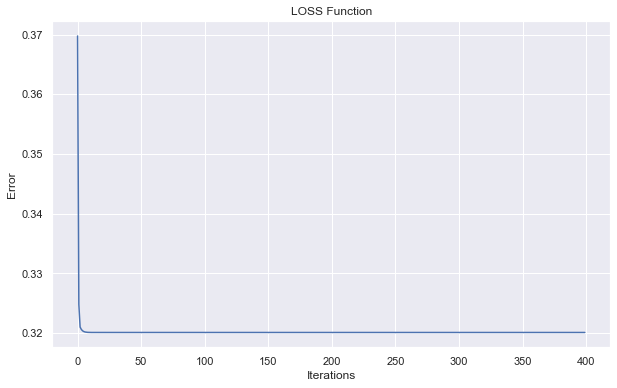

In [544]:
iterate = np.arange(0,400)

plt.title("LOSS Function") 
plt.xlabel("Iterations") 
plt.ylabel("Error") 
plt.plot(iterate,model) 
plt.show()

In [547]:
f1_score_tr = f1_score(y_tr,y_trained)
f1_score_te = f1_score(y_te,y_pred)

IndexError: list index out of range

In [546]:
print(f1_score_tr)

1.0


**Training the IN_BUILD  Logistic Regression Model**

In [124]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [125]:
model.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [127]:
y_predicted = model.predict(X_test)

**Model Results**

In [128]:
#Binary Prediction
model.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [129]:
#Probability Prediction (0,1)
model.predict_proba(X_test)

array([[0.8488316 , 0.1511684 ],
       [0.85089007, 0.14910993],
       [0.87683849, 0.12316151],
       ...,
       [0.88273772, 0.11726228],
       [0.87765915, 0.12234085],
       [0.86013642, 0.13986358]])

In [130]:
#Model Accuracy
model.score(X_test,y_test)

0.8774617067833698

In [131]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [132]:
def prediction_function(Humidity):
    z = 0.042 * Humidity - 1.53 # 0.04150133 ~ 0.042 and -1.52726963 ~ -1.53
    y = sigmoid(z)
    return y

In [133]:
#Make easy prediction by changing value of Humidity
Humidity= 20
prediction_function(Humidity)

0.3340330732481797

In [134]:
# Show the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predicted)

array([[2005,    0],
       [ 280,    0]], dtype=int64)